# Feature Sets Experiments

In this notebook we analyse results obtained from the feature sets experiments. The experimental design is as follows:

2. Let $m$ represent the machine learning model where $m$ $\in$ `["ADA", "LR", "DT", "RF"]`
3. Let $full$, $train$ and $test$ represent the full, training & testing subsets respectively. $train$ and $test$ are $0.75$ and $0.25$ of $full$ respectively
4. Let $train_{n}$ and $test_{n}$ be sub-subsets of the corresponding subsets where `n` $\in$ `[3, max(num_features)]`
5. Let $m\prime_{n}$ be the model trained using $train_{n}$
6. Let $\hat{y}_{n, m\prime}$ be the predictions obtained from $m\prime_{n}$ on $test_{n}$
7. Let $d$ represent the group fairness metric where $d$ $\in$ `["DI", "SPD"]`
7. Let $v_{test, n, d}$ be data fairness metrics calculated using $test_{n}$. Similarly, let $v_{train, n, d}$ be data fairness metrics calculated using $train_{n}$
1. Let $v_{n, m\prime, d}$ be the model fairness metrics calculated using $\hat{y}_{n, m\prime}$
1. We can reduce the granularity a bit for the analysis by considering the fairness metrics across the sub-subsets. Let $v_{test, d}$, $v_{train, d}$ and $v_{m\prime, d}$ represent the fairness metrics across the sub-subsets.

The objective is to analyse the following:
1. Relationship between $v_{test, d}$ and $v_{m\prime, d}$
2. Relationship between $v_{train, d}$ and $v_{m\prime, d}$
3. And finally relationship between $v_{test, d}$, $v_{train, d}$ and $v_{m\prime, d}$

Our hypothesis is that $v_{test/train, d}$ and $v_{m\prime, d}$ have some form of relationship. Another way of formulating the above statement is that the two random variables have similar distribution.

We employ two types of tests to verify our hypothesis:
1. Correlation and
2. Linear regression

In [2]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro, chi2
from sklearn.linear_model import LinearRegression

ROOTDIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
REPORTDIR = os.path.join(ROOTDIR, "report")
DATADIR = os.path.join(ROOTDIR, "data")
sys.path.insert(0, ROOTDIR)


In [3]:
import glob
from src.data import process

batch1 = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-feature-sets-*-25.csv"))]
batch2 = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-feature-sets-*-25-2.csv"))]

batch1 = pd.concat(batch1)
batch2 = pd.concat(batch2)

# we need to reset the `iteration` column for the second batch
# since we use this column as the index when calculating the
# correlation (see correlation cell below) & we cannot have
# duplicates in this column
batch2["iteration"] = batch2["iteration"] + 25
data = pd.concat([batch1, batch2])
data.shape

(112500, 26)

In [4]:
# preprocessing the data prior to analysis
# 1. fairness metrics are only calculated when privileged == None
# 2. scale fairness metrics according to zhang2021ignorance paper
# 3. combine dataset_label & protected
# 4. set the index to iteration
# 4. drop unused columns
# 4. rename column names
# 4. rename model names
data = data[data["privileged"] == "None"]
process(data)
data["dataset_label"] = data["dataset_label"] + "-" + data["protected"].str.lower()
data = data.rename(columns={
    "dataset_label": "dataset",
    "subset_label": "subset",
    "disparate_impact": "DI",
    "statistical_parity_difference": "SPD",
})
data = data.set_index("iteration")
data = pd.concat([
    data.loc[(data["subset"] == "train")], # DFM
    data.loc[(data["subset"] == "test") & (data["model"] != "None")], # MFM
])
data = data[[
    "DI",
    "SPD",
    "num_features",
    "model",
    "dataset",
    "f1",
    "accuracy",
]]
data.loc[(data["model"] == "logisticregression"), "model"] = "LR"
data.loc[(data["model"] == "randomforestclassifier"), "model"] = "RF"
data.loc[(data["model"] == "adaboostclassifier"), "model"] = "ADA"
data.loc[(data["model"] == "decisiontreeclassifier"), "model"] = "DT"

data.shape

(31250, 7)

## Data validation

In this section I am performing some data quality checks to ensure that the data collection scripts worked as expected.

In [7]:
# in this cell I am doing some manual checks to make
# sure I am sampling the data correctly by checking
# the shape of the dataset

# each vector should contain num_features*50 points
datasets = ["german-age", "german-sex", "compas-race", "compas-sex", "meps-race", "bank-age", "adult-race", "adult-sex"]
models = data["model"].unique().tolist()
models.remove("None")

for dataset in datasets:
    _ = data.loc[
        (data["dataset"] == dataset) &
        (data["model"] == "None")
    ]
    assert _.shape[0] == len(_["num_features"].unique().tolist())*50

    _ = data.loc[
        (data["dataset"] == dataset) &
        (data["model"] == "None")
    ]
    assert _.shape[0] == len(_["num_features"].unique().tolist())*50


    for model in models:
        _ = data.loc[
            (data["dataset"] == dataset) &
            (data["model"] == model)
        ]
    assert _.shape[0] == len(_["num_features"].unique().tolist())*50

# Shapiro-wilk test for normality
In this section we employ the Shapiro-Wilk test for normality. The test is as follows:

- $H_o$: the population is normally distributed
- $H_1$: the population is not normally distributed

In [68]:
pvalues = {
    "dataset": [],
    "subset": [],
    "model": [],
    "DI": [],
    "SPD": [],
}

for dataset in datasets:
    _ = data.loc[("test")]
    _ = _[
        (_["dataset"] == dataset) &
        (_["model"] == "None")
    ]
    pvalues["dataset"].append(dataset)
    pvalues["subset"].append("test")
    pvalues["model"].append("None")
    pvalues["DI"].append(shapiro(_["DI"]).pvalue)
    pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

    _ = data.loc[("train")]
    _ = _[
        (_["dataset"] == dataset) &
        (_["model"] == "None")
    ]
    pvalues["dataset"].append(dataset)
    pvalues["subset"].append("train")
    pvalues["model"].append("None")
    pvalues["DI"].append(shapiro(_["DI"]).pvalue)
    pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

    for model in models:
        _ = data[
            (data["dataset"] == dataset) &
            (data["model"] == model)
        ]
        pvalues["dataset"].append(dataset)
        pvalues["subset"].append("test")
        pvalues["model"].append(model)
        pvalues["DI"].append(shapiro(_["DI"]).pvalue)
        pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

pvalues = pd.DataFrame(data=pvalues)
pvalues["DI"] = pvalues["DI"].apply(
    lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t])
)
pvalues["SPD"] = pvalues["SPD"].apply(
    lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t])
)
pvalues


,dataset,subset,model,DI,SPD
0,compas-sex,test,None,,
1,compas-sex,train,None,,
2,compas-sex,test,LR,**,***
3,compas-sex,test,DT,,***
4,compas-sex,test,ADA,***,***
5,compas-sex,test,RF,,**
6,german-age,test,None,**,***
7,german-age,train,None,,
8,german-age,test,LR,**,***
9,german-age,test,DT,***,***


# Distributional Analysis
In this section we analyse the distribution of the fairness metrics. We employ the following methods:

1. Distribution of the data fairness metrics (and model fairness metrics) when $num\_features = max(num\_features)$
2. Distribution of the data fairness metrics (and model fairness metrics) within each $num\_features$
3. Distribtion of the data fairness metrics (and model fairness metrics) across each $num\_features$

We limit our analysis first to the adult-sex dataset.

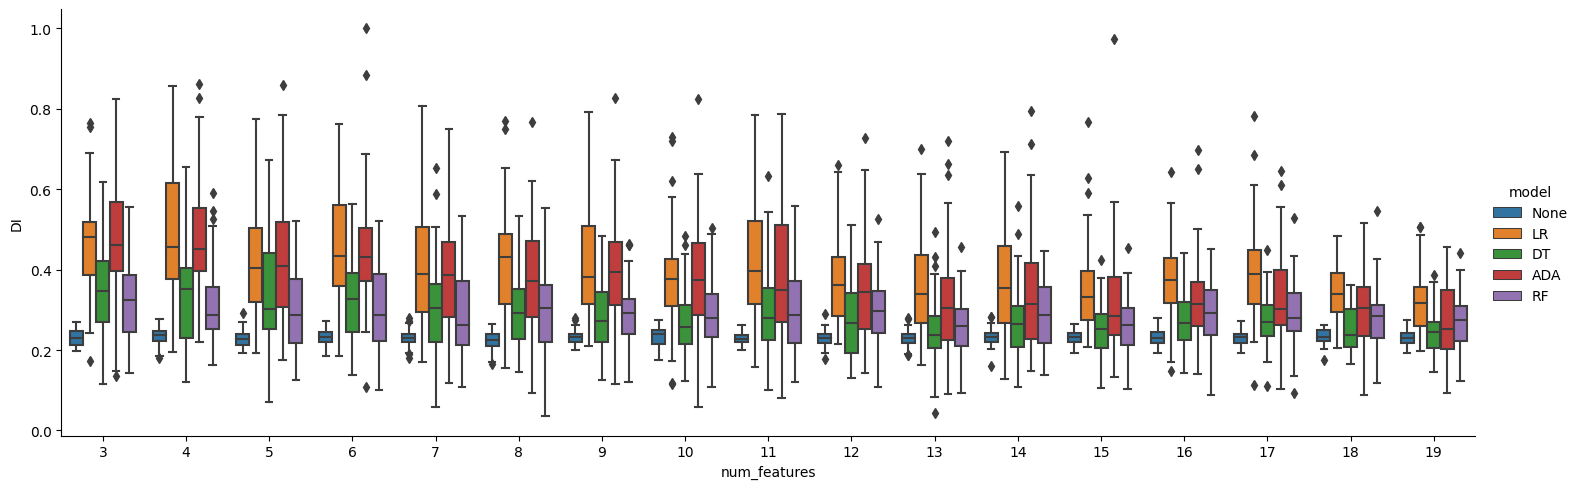

In [43]:
sns.catplot(
    data=data[data["dataset"] == "bank-age"],
    kind="box",
    x="num_features",
    y="DI",
    hue="model",
    aspect=3,
)

# Relational analysis

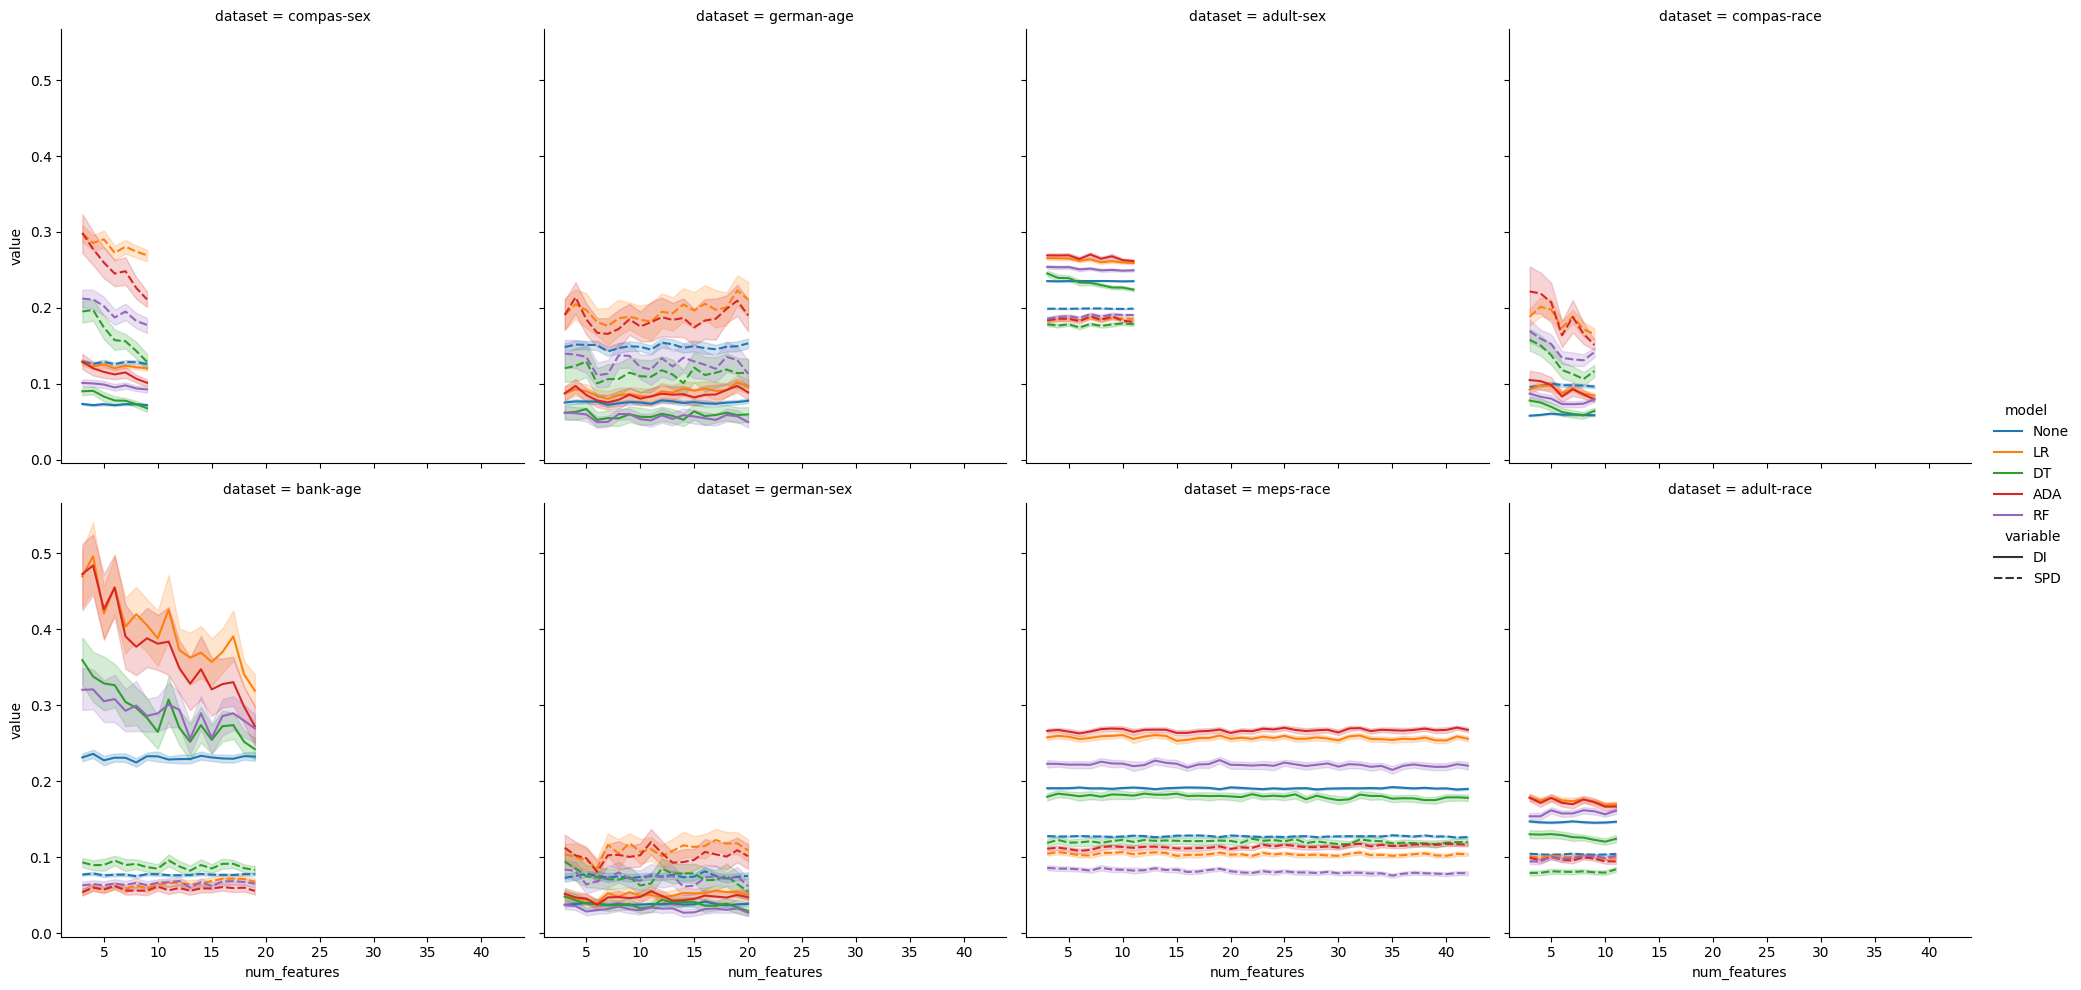

In [41]:
id_vars = ["num_features", "model", "dataset", "accuracy", "f1"]

sns.relplot(
    kind='line',
    data=data.melt(id_vars=id_vars),
    x="num_features",
    y="value",
    hue="model",
    style="variable",
    col="dataset",
    col_wrap=4,
)

Text(0.5, 1.0, 'adult-race')

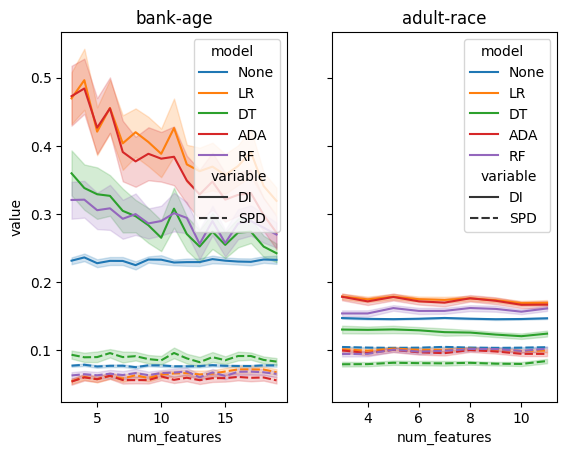

In [47]:
id_vars = ["num_features", "model", "dataset", "accuracy", "f1"]

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    sharey=True,
)

ax = axs[0]
_ = data[(data["dataset"] == "bank-age")]
sns.lineplot(
    data=_.melt(id_vars=id_vars),
    x="num_features",
    y="value",
    hue="model",
    style="variable",
    ax=ax,
)
ax.set_title("bank-age")

ax = axs[1]
_ = data[(data["dataset"] == "adult-race")]
sns.lineplot(
    data=_.melt(id_vars=id_vars),
    x="num_features",
    y="value",
    hue="model",
    style="variable",
    ax=ax,
)
ax.set_title("adult-race")

# name = "lineplot--num-features--di-spd--bank-age.pdf"
# fig.savefig(os.path.join(REPORTDIR, name), format="pdf")

# name = "lineplot--num-features--di-spd--bank-age.png"
# fig.savefig(os.path.join(REPORTDIR, name), format="png")

## Correlation
In this section we employ correlation to test if there is a relationship between the data & model metrics. From the section above, we note that the distribution of the populations are not normal.

We use the Spearman's correlation since it does not assume normality & is robust to outliers.

We will create individual tables for each subset (train & test).

$$
DI = \frac{P(y=1 | D=unprivileged)}{P(y=1 | D=privileged)}
$$
$$
SPD = P(y=1 | D=unprivileged) - P(y=1 | D=privileged)
$$

In [44]:
from scipy.stats import spearmanr

indices = [[
    "DI",
    "SPD",
],
models]
corr = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))
corr_pvalues = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))

for d in datasets:
    _ = data[
        (data["dataset"] == d)
    ]
    for metric in ["DI", "SPD"]:
        _pivots = []
        for n in _["num_features"].unique().tolist():
            _pivots.append(pd.pivot(
                data=_[_["num_features"] == n],
                columns="model",
                values=metric,
            ))
        pivoted = pd.concat(_pivots)
        for model in models:
            c, p = spearmanr(pivoted[model], pivoted["None"])
            corr.loc[(metric, model), d] = c
            corr_pvalues.loc[(metric, model), d] = p

corr

german-age german-sex compas-race compas-sex meps-race  bank-age  \
metric model                                                                    
DI     LR      0.052725  -0.021581    0.295859   0.223336 -0.194446 -0.153758   
       DT       0.05838   0.018312    0.011591   0.040935 -0.079732 -0.132081   
       ADA     0.064279   0.072153    0.066226    0.12414 -0.189706 -0.148982   
       RF      0.002578  -0.133686    0.088987   0.098857 -0.199683 -0.165327   
SPD    LR      0.048823  -0.023801    0.285643   0.211098 -0.194669 -0.173914   
       DT      0.054094   0.012901    0.020885   0.040948 -0.089753 -0.158716   
       ADA     0.062317   0.070518    0.042289   0.128078 -0.195979 -0.179555   
       RF     -0.007212  -0.139032     0.09027   0.099066 -0.157593 -0.189575   

             adult-race adult-sex  
metric model                       
DI     LR     -0.200347 -0.240963  
       DT     -0.138497 -0.049295  
       ADA    -0.175491 -0.226526  
       RF     -0.257292 -0.228266  
SPD    LR     -0.204617 -0.265361  
       DT     -0.193741 -0.195322  
       ADA    -0.181749  -0.17264  
       RF     -0.264919 -0.222428

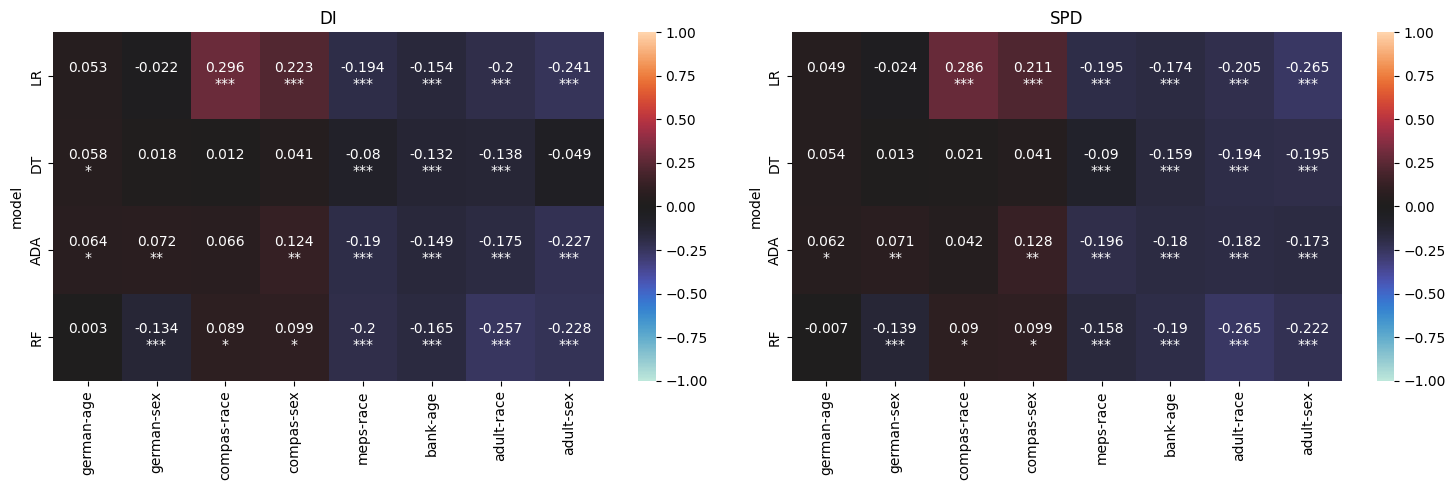

In [45]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 5)
)

for idx, metric in enumerate(["DI", "SPD"]):
    ax = axs[idx]
    ax.set_title(metric)
    _ = corr.loc[(metric)].astype(float)
    _corr = _.round(3).astype(str)
    _sig = corr_pvalues.loc[(metric)].applymap(
        lambda x: ''.join(['*' for t in [0.01, 0.05, 0.1] if x<=t])
    )
    annot = _corr + "\n" + _sig
    sns.heatmap(
        data=_,
        annot=annot,
        fmt="",
        vmin=-1.,
        vmax=1.,
        center=0.,
        ax=ax,
    )

fig.tight_layout()

name = "heatmap--corr--num-features.pdf"
fig.savefig(os.path.join(REPORTDIR, name), format="pdf")

name = "heatmap--corr--num-features.png"
fig.savefig(os.path.join(REPORTDIR, name), format="png")

## Linear Regression
In this section we employ linear regression to analyse relationship between the data & model fairness metrics.

We collect the following metrics:

1. min, max & avg for $v_{test/train, d}$
2. min, max & avg for $v_{m\prime, d}$
3. coefficient(slope) of the linear regression model

In [11]:

d = {
    "dataset": [],
    "model": [],
    "metric": [],
    "intercept": [],
    "slope": [],
    "r2": [],
    "f_pvalue": [],
    "fvalue": [],
    "llf": [],
    "mse_model": [],
    "mse_resid": [],
    "mse_total": [],
    # "pvalues": [],
    "ssr": [],
    # "tvalues": [],
}

for dataset in datasets:
    for model in models:
        for metric in ["DI", "SPD"]:
            x = data.loc[
                (data["dataset"] == dataset) &
                (data["model"] == "None"),
                metric
            ].values.reshape(-1, 1)
            y = data.loc[
                (data["dataset"] == dataset) &
                (data["model"] == model),
                metric
            ].values.reshape(-1, 1)
            mod = sm.OLS(
                endog=y,
                exog=sm.tools.add_constant(x),
            )
            res = mod.fit()

            d["dataset"].append(dataset)
            d["model"].append(model)
            d["metric"].append(metric)
            d["intercept"].append(res.params[0])
            d["slope"].append(res.params[1])
            d["r2"].append(res.rsquared)
            d["f_pvalue"].append(res.f_pvalue)
            d["fvalue"].append(res.fvalue)
            d["llf"].append(res.llf)
            d["mse_model"].append(res.mse_model)
            d["mse_resid"].append(res.mse_resid)
            d["mse_total"].append(res.mse_total)
            d["ssr"].append(res.ssr)

reg = pd.DataFrame(data=d)
reg


,dataset,model,metric,intercept,slope,r2,f_pvalue,fvalue,llf,mse_model,mse_resid,mse_total,ssr
0,german-age,LR,DI,0.074289,0.200128,0.003906,6.089112e-02,3.521789,1716.322960,0.004559,0.001294,0.001298,1.162377
1,german-age,LR,SPD,0.163150,0.215909,0.003788,6.496188e-02,3.414316,994.790859,0.021965,0.006433,0.006450,5.776924
2,german-age,DT,DI,0.046062,0.168136,0.002576,1.281667e-01,2.318849,1685.031230,0.003218,0.001388,0.001390,1.246082
3,german-age,DT,SPD,0.091648,0.147775,0.002114,1.681823e-01,1.902141,1072.789831,0.010289,0.005409,0.005415,4.857580
4,german-age,ADA,DI,0.065279,0.269970,0.006536,1.526948e-02,5.907730,1679.687041,0.008296,0.001404,0.001412,1.260968
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,adult-sex,DT,SPD,0.330773,-0.770455,0.037987,3.141071e-05,17.690109,1515.947103,0.001233,0.000070,0.000072,0.031236
60,adult-sex,ADA,DI,0.565813,-1.273277,0.058319,2.153618e-07,27.745200,1444.904659,0.002653,0.000096,0.000101,0.042834
61,adult-sex,ADA,SPD,0.384349,-1.003324,0.034358,7.639264e-05,15.939980,1373.666402,0.002092,0.000131,0.000136,0.058788
62,adult-sex,RF,DI,0.442713,-0.814771,0.040694,1.619362e-05,19.004280,1560.664276,0.001086,0.000057,0.000059,0.025606


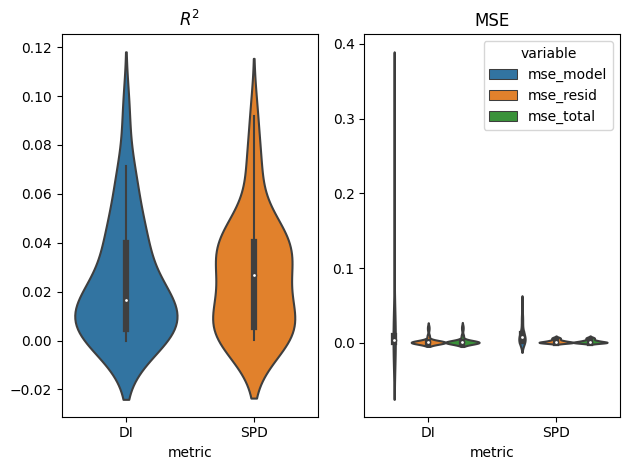

In [12]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
)


ax = axs[0]
ax.set_title("$R^2$")
sns.violinplot(
    data=reg,
    y="r2",
    x="metric",
    ax=ax,
)
ax.set_ylabel(None)

ax = axs[1]
ax.set_title("MSE")
_ = reg.loc[:, ["metric", "mse_model", "mse_resid", "mse_total"]]
_ = _.melt(id_vars=["metric"])
sns.violinplot(
    data=_,
    x="metric",
    y="value",
    hue="variable",
    ax=ax,
)
ax.set_ylabel(None)

fig.tight_layout()


# Analysis of correlation across $num\_features$

In [48]:
d = {
    "metric": [],
    "num_features": [],
    "corr": [],
    "model": [],
    "dataset": [],
}

for dataset in datasets:
    _ = data[data["dataset"] == dataset]
    for metric in ["DI", "SPD"]:
        for n in _["num_features"].unique().tolist():
            pivot = pd.pivot(
                data=_[_["num_features"] == n],
                columns="model",
                values=metric,
            )
            for model in models:
                c, p = spearmanr(pivot[model], pivot["None"])
                d["metric"].append(metric)
                d["num_features"].append(n)
                d["corr"].append(c)
                d["model"].append(model)
                d["dataset"].append(dataset)

corr = pd.DataFrame(data=d)
corr

,metric,num_features,corr,model,dataset
0,DI,3,-0.153613,LR,german-age
1,DI,3,0.140456,DT,german-age
2,DI,3,-0.118463,ADA,german-age
3,DI,3,-0.205095,RF,german-age
4,DI,4,0.037983,LR,german-age
...,...,...,...,...,...
995,SPD,10,-0.266651,RF,adult-sex
996,SPD,11,-0.398319,LR,adult-sex
997,SPD,11,-0.129124,DT,adult-sex
998,SPD,11,-0.464490,ADA,adult-sex


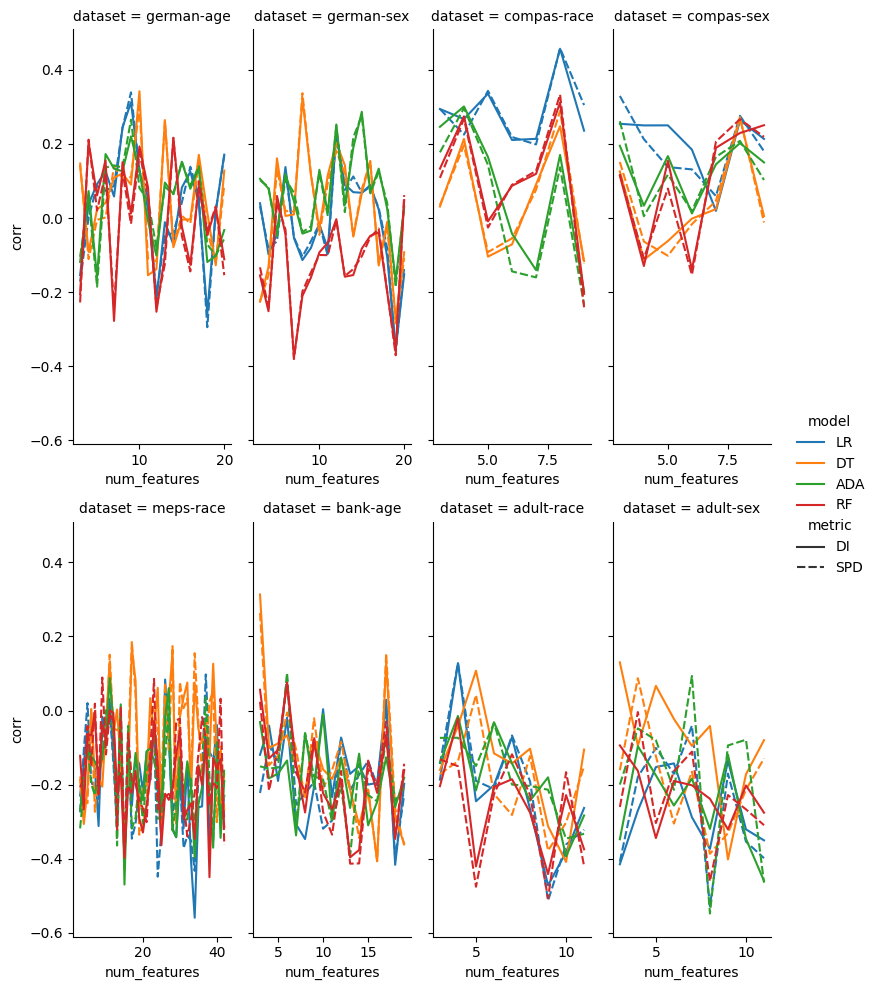

In [50]:
g = sns.relplot(
    kind="line",
    data=corr,
    hue="model",
    style="metric",
    x="num_features",
    y="corr",
    errorbar=None,
    col="dataset",
    col_wrap=4,
    aspect=0.4,
    facet_kws={"sharex": False}
)
g.tight_layout()

name = "lineplot--num-features--corr.pdf"
g.savefig(os.path.join(REPORTDIR, name), format="pdf")

name = "lineplot--num-features--corr.png"
g.savefig(os.path.join(REPORTDIR, name), format="png")
